In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

In [15]:
BUILD_DATA = True

class HairNetData():
    IMG_DIR = 'training-data/gaussian/images'
    IMG_SIZE = 200  # 200x200
    PARAM_DIR = 'training-data/gaussian/parameters.csv'
    data = []
    data_count = 0
    
    def open_data(self):
        params_df = pd.read_csv(self.PARAM_DIR)
        
        for file in tqdm(os.listdir(self.IMG_DIR)):
            try:
                # load image
                path = os.path.join(self.IMG_DIR, file)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                # load param for the image
                param = params_df.loc[params['file_name'] == file] # get params with that file name
                param.drop(columns=['file_name']) # drops filename column

                # adding to data
                self.data.append([np.array(img), param.to_numpy()])
                self.data_count += 1
            except Exception as e:
                print(str(e))
            
        assert self.data_count == 3000
        np.random.shuffle(self.data)
        np.save('data.npy', self.data)
        print(f'count: {self.data_count}')
        

        
if BUILD_DATA:
    hairnetdata = HairNetData()
    hairnetdata.open_data()
    BUILD_DATA = False


100%|██████████| 3000/3000 [00:09<00:00, 316.27it/s]
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


count: 3000


In [16]:
data = np.load('data.npy', allow_pickle=True)

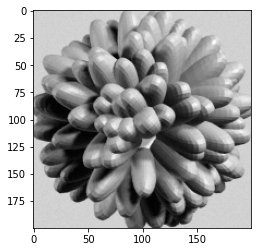

In [24]:
import matplotlib.pyplot as plt

plt.imshow(data[2999][0], cmap='gray')
plt.show()